In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import re
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
city = "San Francisco"
num = 250
test_size = 30 # do not use lot of test data, or else it will come a constant
split_point_train = 200
data = pd.DataFrame([])

humidity = pd.read_csv("time-series-datasets/historical-hourly-weather-data/humidity.csv")
data['humidity'] = humidity[city][:num]
data["datetime"] = humidity["datetime"][:num]
pressure = pd.read_csv("time-series-datasets/historical-hourly-weather-data/pressure.csv")
data['pressure'] = pressure[city][:num]
temperature = pd.read_csv("time-series-datasets/historical-hourly-weather-data/temperature.csv")
data['temperature'] = temperature[city][:num]
wind_speed = pd.read_csv("time-series-datasets/historical-hourly-weather-data/wind_speed.csv")
data['wind_speed'] = wind_speed[city][:num]

In [3]:
print(data.shape)
data = data.dropna(how = "any")
print(data.shape)

(250, 5)
(249, 5)


In [4]:
data.describe()

,humidity,pressure,temperature,wind_speed
count,249.000000,249.000000,249.000000,249.000000
mean,68.461847,1014.481928,291.009588,2.746988
std,18.367649,4.165996,4.555006,2.215288
min,11.000000,1000.000000,283.930000,0.000000
25%,59.000000,1011.000000,287.930000,1.000000
50%,72.000000,1015.000000,289.690000,3.000000
75%,82.000000,1017.000000,293.600000,4.000000
max,100.000000,1026.000000,304.860000,11.000000


In [5]:
date = pd.to_datetime(data.datetime, format = "%Y-%m-%d %H:%M")
data.index = date
data = data.drop(["datetime"], axis = 1)
data.head()

,humidity,pressure,temperature,wind_speed
datetime,,,,
2012-10-01 13:00:00,88.0,1009.0,289.480000,2.0
2012-10-01 14:00:00,87.0,1009.0,289.474993,2.0
2012-10-01 15:00:00,86.0,1009.0,289.460618,2.0
2012-10-01 16:00:00,85.0,1009.0,289.446243,2.0
2012-10-01 17:00:00,84.0,1009.0,289.431869,2.0


In [6]:
test = data[split_point_train:]
train = data[:split_point_train]

In [7]:
test = data[-test_size:]
train = data[:-test_size]    

In [8]:
train.shape, test.shape

((219, 4), (30, 4))

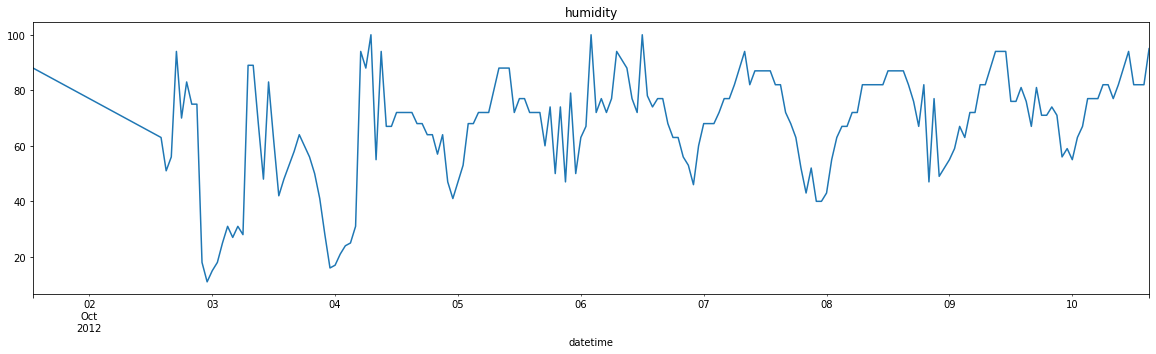

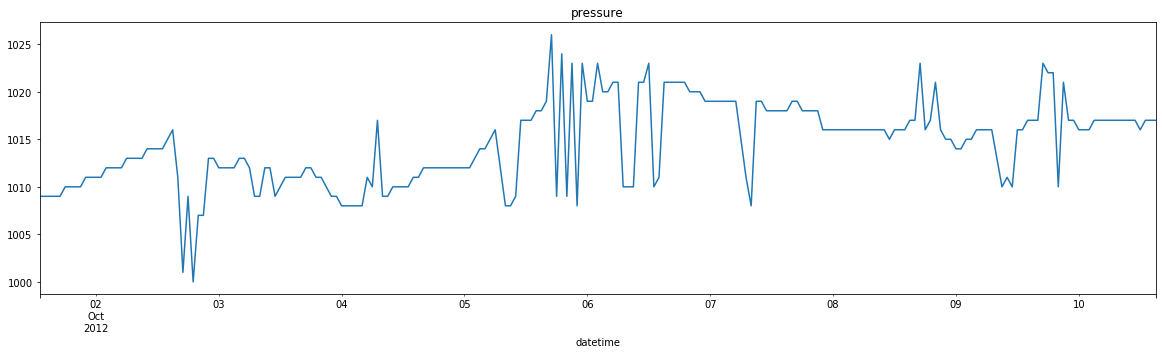

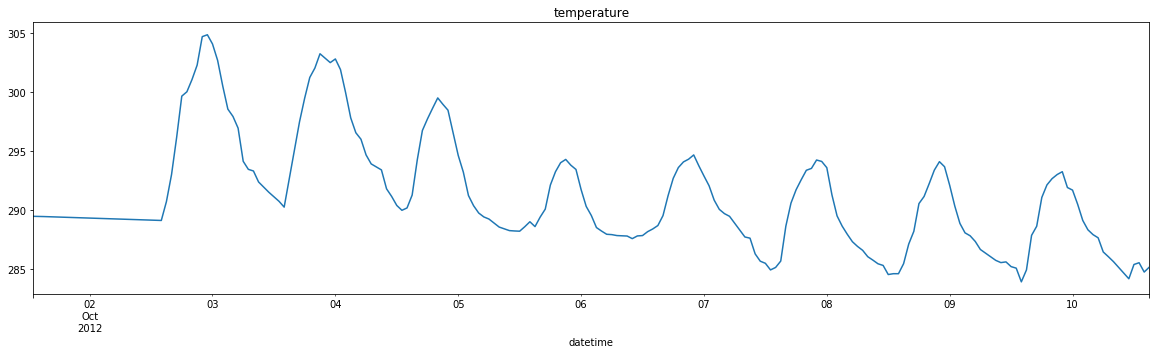

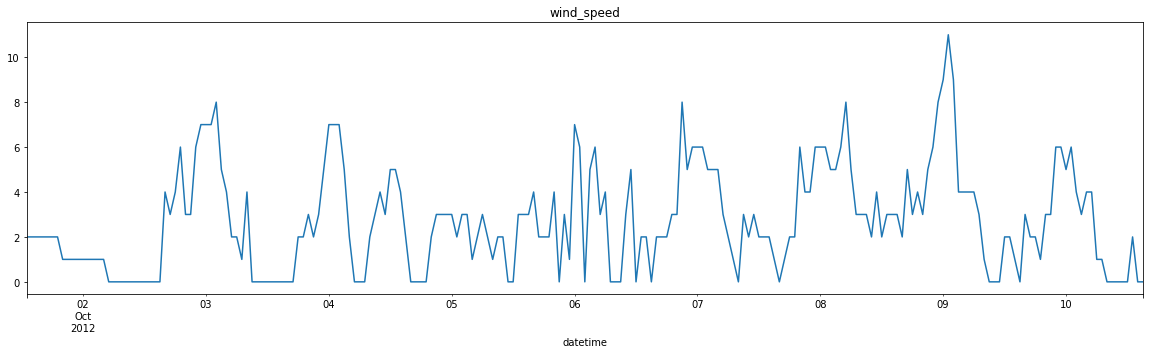

In [10]:
data = data.astype(float)

for cl in data.columns:
    if cl == "description":
        plt.figure(figsize = (20,5))
        descr = train.groupby(["description"]).count()["humidity"]
        good = descr[descr >= 2000]
        bed = descr[descr < 2000]
        good["other"] = sum(bed)
        plt.bar(good.index, good)
        continue
    plt.figure(figsize = (20,5))
#     plt.scatter(data.index, data[cl])
    train[cl].plot(title = cl)
    plt.show()

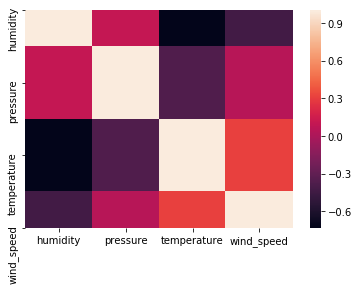

In [13]:
import seaborn as sns
corr_data = data.corr()
sns.heatmap(corr_data)

# Check the stationarity

For this we have to find **eigenvalues** of matrix Ф. To learn more how do we find the matrix Ф here: https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/

The idea is to conduct **Johansen’s test**, that will give us the eigenvalues. 

1) eigenvalues < 1 => **stationary**

2) eigenvalues > 1 => non-stationary


In [14]:
coint_johansen(data,-1,1).eig 

array([1.63047355e-01, 1.39740250e-01, 7.15229039e-02, 1.60942354e-05])

## Apply VAR model

In [15]:
model = VAR(endog = data)
model_fit = model.fit(maxlags = 14) ### maxlags - the order of VAR process == p 

d:\it\anaconda3\envs\jsp\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [16]:
preds_var = model_fit.forecast(train.values.tolist(), steps = len(test)) ### steps - how much data forward you want to predict 

preds_var = preds_var.transpose()

for i, cl in enumerate(data.columns):
    print('mse value for ', cl, ' is : ', mean_squared_error(preds_var[i], test[cl]))
    print('rmse value for ', cl, ' is : ', np.sqrt(mean_squared_error(preds_var[i], test[cl])))
    print('mae value for ', cl, ' is : ', mean_absolute_error(preds_var[i], test[cl]))

mse value for  humidity  is :  164.70491851488129
rmse value for  humidity  is :  12.833741407511734
mae value for  humidity  is :  10.976132053712394
mse value for  pressure  is :  7.832863449764097
rmse value for  pressure  is :  2.7987253258875007
mae value for  pressure  is :  2.5782558957177835
mse value for  temperature  is :  4.70305771318523
rmse value for  temperature  is :  2.1686534331665883
mae value for  temperature  is :  1.8127718703581706
mse value for  wind_speed  is :  3.3398355038235414
rmse value for  wind_speed  is :  1.8275216835440125
mae value for  wind_speed  is :  1.652605736454982


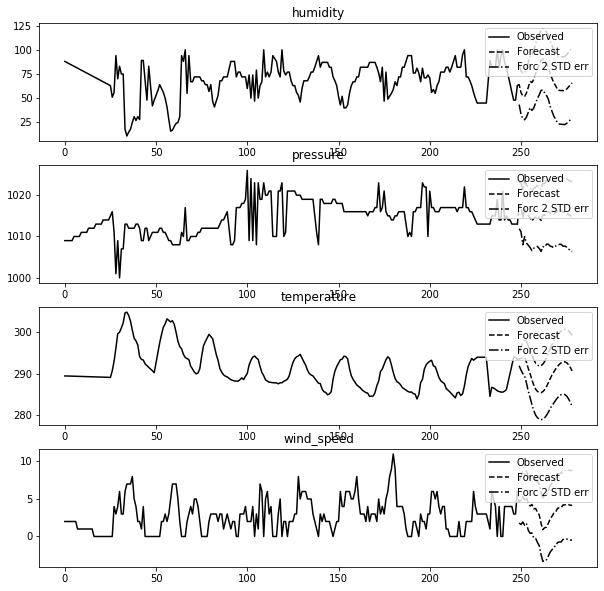

In [17]:
model_fit.plot_forecast(len(test))
plt.show()

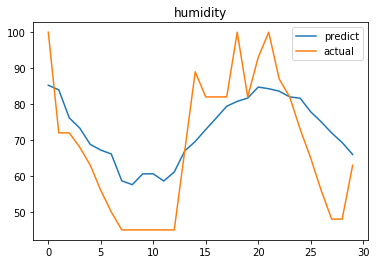

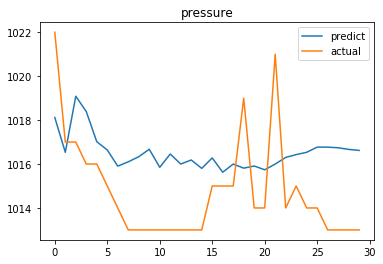

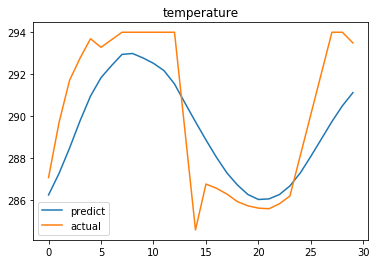

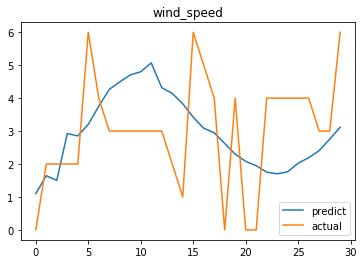

In [18]:
for i, col in enumerate(test.columns):
    plt.plot(range(len(preds_var[i])), preds_var[i], label = "predict")
    plt.plot(range(len(test[col])), test[col], label = "actual")
    plt.legend()
    plt.title(col)
    plt.show()

In [22]:
# find the best maxlags parameter
res = dict()
for i in range(1,20):
    model_fit = model.fit(maxlags = i)
    preds = model_fit.forecast(train.values.tolist(), steps = len(test))
    preds = preds.transpose()
    error = 0
    for j, cl in enumerate(train.columns):
        error = error + np.sqrt(mean_squared_error(preds[j], test[cl]))
    res[i] = error

In [23]:
min(res, key = res.get) # best order for model

18

## Apply VARMAX model 

In [24]:
model = VARMAX(endog = train, order = (11,0))
model_fit = model.fit(maxlags = 11)

d:\it\anaconda3\envs\jsp\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [25]:
preds_varmax = model_fit.forecast(steps = len(test)) ### steps - how much data forward you want to predict 

preds_varmax = preds_varmax.transpose()

for i, cl in enumerate(train.columns):
    print('mse value for ', cl, ' is : ', mean_squared_error(preds_varmax.loc[cl], test[cl]))
    print('rmse value for ', cl, ' is : ', np.sqrt(mean_squared_error(preds_varmax.loc[cl], test[cl])))
    print('mae value for ', cl, ' is : ', mean_absolute_error(preds_varmax.loc[cl], test[cl]))

mse value for  humidity  is :  196.13539297037494
rmse value for  humidity  is :  14.004834628455095
mae value for  humidity  is :  12.173743550657825
mse value for  pressure  is :  8.641542953448289
rmse value for  pressure  is :  2.939650141334558
mae value for  pressure  is :  2.6068675011566786
mse value for  temperature  is :  6.312182516849799
rmse value for  temperature  is :  2.5124057229774412
mae value for  temperature  is :  2.078581930742204
mse value for  wind_speed  is :  3.7198218603667925
rmse value for  wind_speed  is :  1.9286839710970776
mae value for  wind_speed  is :  1.743530571252253


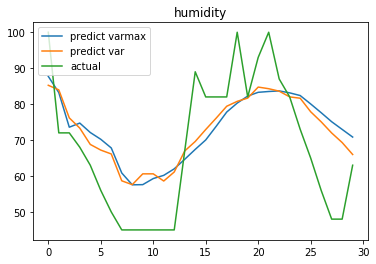

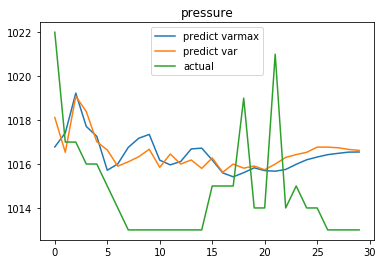

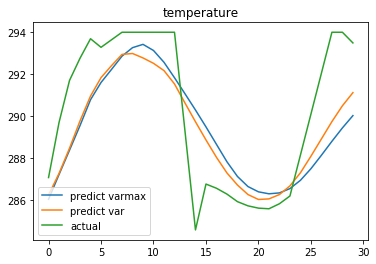

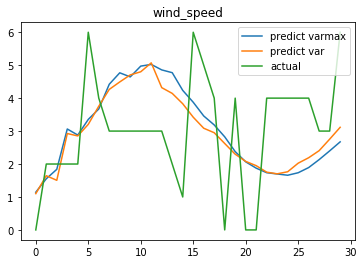

In [26]:
for i, col in enumerate(test.columns):
    plt.plot(range(len(preds_varmax.loc[col])),preds_varmax.loc[col], label = "predict varmax")
    plt.plot(range(len(preds_var[i])), preds_var[i], label = "predict var")
    plt.plot(range(len(test[col])), test[col], label = "actual")
    plt.legend()
    plt.title(col)
    plt.show()

In [ ]:
# find the best p , q parameter
res = dict()
for q in range(0,10):
    for p in [7,10,11]:
        model = VARMAX(endog = train, order = (p,q))
        model_fit = model.fit(maxlags = p)
        preds = model_fit.forecast(steps = len(test))
        preds = preds.transpose()
        error = 0
        for j, cl in enumerate(test.columns):
            error = error + np.sqrt(mean_squared_error(preds.loc[cl], test[cl]))
        res[tuple([p,q])] = error
        print("{},{} is done, error = {}".format(p,q, error))

d:\it\anaconda3\envs\jsp\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


7,0 is done, error = 23.025757223991874


d:\it\anaconda3\envs\jsp\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


10,0 is done, error = 21.74968085439021


d:\it\anaconda3\envs\jsp\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [ ]:
min(res, key = res.get) # best p, q for model

# Keras 

In [619]:
import keras
from keras import Sequential
from keras.layers import LSTM 
from keras.layers import Dense 
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import TimeDistributed

## Transport data for NN

In [654]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    cols, names = list(), list()
    df = pd.DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [j + "(t-{})".format(i) for j in data.columns]
    # forecast sequence (t, t+1, ... t+n) 
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [j + "(t)" for j in data.columns]
        else:
            names += [j + "(t+{})".format(i) for j in data.columns]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True) #any
    return agg

In [655]:
# prepare and split data
def split_prepare(data, p, test_size = 0.2, scale = True, show = False):
    supervised = series_to_supervised(data,p,1)
    supervised = supervised.drop(["humidity(t)","pressure(t)", "wind_speed(t)"], axis = 1)
    
    if scale:
        scaler = MinMaxScaler(feature_range=(0, 1))
        supervised_scaled = scaler.fit_transform(supervised)
        supervised = pd.DataFrame(supervised_scaled, columns = supervised.columns)
        
    if show:
        print(supervised.head())
    
    
    if test_size > 1:
        train = supervised[:-test_size]    
        test = supervised[-test_size:]
    else:
        test_size = int(test_size*data.shape[0])
        train = supervised[:-test_size]    
        test = supervised[-test_size:]
        
        
    if show:
        print("train/test sizes are: {}, {}".format(train.shape, test.shape))
    
    features = list(supervised.columns)
    features.remove("temperature(t)")
    train_X, train_y = train[features].values, train[["temperature(t)"]].values
    test_X, test_y = test[features].values, test[["temperature(t)"]].values
    return train_X, train_y, test_X, test_y

In [656]:
def scale_back_labels(test_X, test_y):
    
    test = pd.DataFrame(test_X, copy = True)
    test["temperature(t)"] = test_y
    
    test_transformed = scaler.inverse_transform(test.values)
    return test_transformed[:,-1]

In [657]:
p = 10 ### global variable!
train_X, train_y, test_X, test_y = split_prepare(data, p, test_size = test_size, scale = True, show = True)

   humidity(t-10)  pressure(t-10)  temperature(t-10)  wind_speed(t-10)  \
0        0.865169        0.346154           0.265170          0.181818   
1        0.853933        0.346154           0.264930          0.181818   
2        0.842697        0.346154           0.264244          0.181818   
3        0.831461        0.346154           0.263557          0.181818   
4        0.820225        0.346154           0.262870          0.181818   

   humidity(t-9)  pressure(t-9)  temperature(t-9)  wind_speed(t-9)  \
0       0.853933       0.346154          0.264930         0.181818   
1       0.842697       0.346154          0.264244         0.181818   
2       0.831461       0.346154          0.263557         0.181818   
3       0.820225       0.346154          0.262870         0.181818   
4       0.808989       0.384615          0.262183         0.181818   

   humidity(t-8)  pressure(t-8)  ...  wind_speed(t-3)  humidity(t-2)  \
0       0.842697       0.346154  ...         0.090909       0.

## Create LSTM

In [658]:
### neeeded for LSTM - time step == const = 1
train_X_lstm = train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
test_X_lstm = test_X.reshape((test_X.shape[0],1, test_X.shape[1]))
train_X_lstm.shape

(209, 1, 40)

In [659]:
### neeeded for LSTM - time step = p - number of previous observations
# (n_samples, n_timesteps, n_features)
train_X_lstm = train_X.reshape((train_X.shape[0],p,4))
test_X_lstm = test_X.reshape((test_X.shape[0],p,4))
train_X_lstm.shape

(209, 10, 4)

In [660]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X_lstm.shape[1], train_X_lstm.shape[2])))
print(model.output_shape)
model.add(Dense(1))
model.compile(loss='mae', optimizer='adadelta')

(None, 50)


Train on 209 samples, validate on 30 samples
Epoch 1/150
209/209 [==============================] - 19s 92ms/step - loss: 0.3037 - val_loss: 0.1905
Epoch 2/150
209/209 [==============================] - 0s 270us/step - loss: 0.2251 - val_loss: 0.1688
Epoch 3/150
209/209 [==============================] - 0s 311us/step - loss: 0.2008 - val_loss: 0.1662
Epoch 4/150
209/209 [==============================] - 0s 272us/step - loss: 0.1949 - val_loss: 0.1651
Epoch 5/150
209/209 [==============================] - 0s 345us/step - loss: 0.1900 - val_loss: 0.1638
Epoch 6/150
209/209 [==============================] - 0s 230us/step - loss: 0.1842 - val_loss: 0.1641
Epoch 7/150
209/209 [==============================] - 0s 250us/step - loss: 0.1798 - val_loss: 0.1631
Epoch 8/150
209/209 [==============================] - 0s 254us/step - loss: 0.1753 - val_loss: 0.1626
Epoch 9/150
209/209 [==============================] - 0s 267us/step - loss: 0.1707 - val_loss: 0.1635
Epoch 10/150
209/209 [======

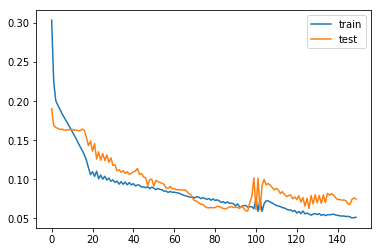

In [661]:
# fit network
history = model.fit(train_X_lstm, train_y, epochs=150, batch_size=72, validation_data=(test_X_lstm, test_y), verbose=1, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [663]:
# make a prediction
preds = model.predict(test_X_lstm)

orignal_preds = scale_back_labels(test_X, preds)
real = scale_back_labels(test_X, test_y)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(real, orignal_preds))
print('Test RMSE for LSTM: ', rmse)
print('Test MAE for LSTM: ', mean_absolute_error(real, orignal_preds))
#print('rmse value for VARMAX is : ', np.sqrt(mean_squared_error(preds_varmax.loc["temperature"], real)))
#print('rmse value for VAR is : ', np.sqrt(mean_squared_error(preds_var[2], real)))

Test RMSE for LSTM:  2.0909164892287775
Test MAE for LSTM:  1.5610553977986077


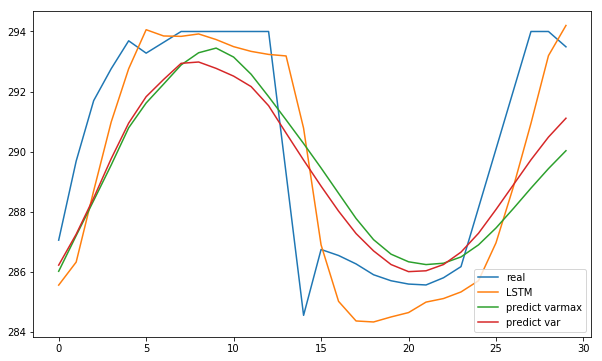

In [683]:
plt.figure(figsize = (10,6))
plt.plot(real, label = "real")
plt.plot(orignal_preds, label = "LSTM")
plt.plot(range(len(preds_varmax.loc["temperature"])),preds_varmax.loc["temperature"], label = "predict varmax")
plt.plot(range(len(preds_var[2])), preds_var[2], label = "predict var")
plt.legend()

## Create CNN

In [671]:
### neeeded for CNN
train_X_cnn = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X_cnn = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
train_X_cnn.shape

(209, 40, 1)

In [672]:
# design network СNN
model = Sequential()
model.add(Conv1D(filters = 32, kernel_size = 2, activation = "relu", input_shape=(train_X_cnn.shape[1], train_X_cnn.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adadelta')

Train on 209 samples, validate on 30 samples
Epoch 1/150
209/209 [==============================] - 11s 54ms/step - loss: 0.4551 - val_loss: 0.3305
Epoch 2/150
209/209 [==============================] - 0s 267us/step - loss: 0.2389 - val_loss: 0.3175
Epoch 3/150
209/209 [==============================] - 0s 291us/step - loss: 0.2717 - val_loss: 0.2637
Epoch 4/150
209/209 [==============================] - 0s 301us/step - loss: 0.2645 - val_loss: 0.2569
Epoch 5/150
209/209 [==============================] - 0s 320us/step - loss: 0.2482 - val_loss: 0.2456
Epoch 6/150
209/209 [==============================] - 0s 272us/step - loss: 0.2499 - val_loss: 0.2759
Epoch 7/150
209/209 [==============================] - 0s 320us/step - loss: 0.2141 - val_loss: 0.2306
Epoch 8/150
209/209 [==============================] - 0s 372us/step - loss: 0.2429 - val_loss: 0.3279
Epoch 9/150
209/209 [==============================] - 0s 391us/step - loss: 0.2034 - val_loss: 0.2336
Epoch 10/150
209/209 [======

Epoch 79/150
209/209 [==============================] - 0s 234us/step - loss: 0.0884 - val_loss: 0.1179
Epoch 80/150
209/209 [==============================] - 0s 191us/step - loss: 0.0959 - val_loss: 0.0821
Epoch 81/150
209/209 [==============================] - 0s 215us/step - loss: 0.0952 - val_loss: 0.1166
Epoch 82/150
209/209 [==============================] - 0s 200us/step - loss: 0.0930 - val_loss: 0.0716
Epoch 83/150
209/209 [==============================] - 0s 196us/step - loss: 0.0667 - val_loss: 0.1339
Epoch 84/150
209/209 [==============================] - 0s 215us/step - loss: 0.0887 - val_loss: 0.0619
Epoch 85/150
209/209 [==============================] - 0s 215us/step - loss: 0.0680 - val_loss: 0.1337
Epoch 86/150
209/209 [==============================] - 0s 200us/step - loss: 0.0870 - val_loss: 0.0825
Epoch 87/150
209/209 [==============================] - 0s 205us/step - loss: 0.1141 - val_loss: 0.0986
Epoch 88/150
209/209 [==============================] - 0s 201us

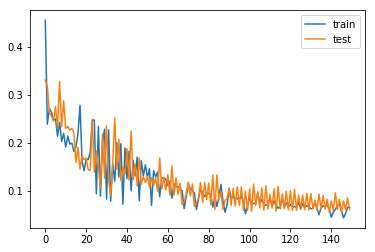

In [673]:
# fit network
history_cnn = model.fit(train_X_cnn, train_y, epochs=150, batch_size=72, validation_data=(test_X_cnn, test_y), verbose=1, shuffle=False)
# plot history
plt.plot(history_cnn.history['loss'], label='train')
plt.plot(history_cnn.history['val_loss'], label='test')
plt.legend()
plt.show()

In [674]:
# make a prediction
preds_cnn = model.predict(test_X_cnn)

orignal_preds_cnn = scale_back_labels(test_X, preds_cnn)
real = scale_back_labels(test_X, test_y)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(real, orignal_preds_cnn))
print('Test RMSE for CNN: ', rmse)
print('Test MAE for CNN: ', mean_absolute_error(real, orignal_preds_cnn))

Test RMSE for CNN:  1.6987053593115229
Test MAE for CNN:  1.2886949045807248


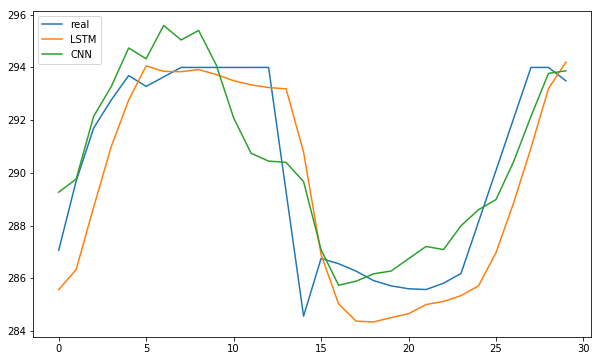

In [684]:
plt.figure(figsize = (10,6))
plt.plot(real, label = "real")
plt.plot(orignal_preds, label = "LSTM")
plt.plot(orignal_preds_cnn, label = "CNN")
#plt.plot(range(len(preds_varmax.loc["temperature"])),preds_varmax.loc["temperature"], label = "predict varmax")
#plt.plot(range(len(preds_var[2])), preds_var[2], label = "predict var")
plt.legend()

## Create CNN + LSTM

In [666]:
### neeeded for CNN + LSTM
train_X_cnn_lstm = train_X.reshape((train_X.shape[0], p, 4, 1))
test_X_cnn_lstm = test_X.reshape((test_X.shape[0], p, 4, 1))
train_X_cnn_lstm.shape, test_X_cnn_lstm.shape

((209, 10, 4, 1), (30, 10, 4, 1))

In [667]:
# design network CNN + LSTM
model = Sequential()
model.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 3, activation = "relu"), input_shape=(None, 4, 1)))
#model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adadelta')

Train on 209 samples, validate on 30 samples
Epoch 1/150
209/209 [==============================] - 21s 101ms/step - loss: 0.3419 - val_loss: 0.2254
Epoch 2/150
209/209 [==============================] - 0s 1ms/step - loss: 0.2650 - val_loss: 0.1877
Epoch 3/150
209/209 [==============================] - 0s 1ms/step - loss: 0.2147 - val_loss: 0.1770
Epoch 4/150
209/209 [==============================] - 0s 1ms/step - loss: 0.1992 - val_loss: 0.1707
Epoch 5/150
209/209 [==============================] - 0s 1ms/step - loss: 0.1899 - val_loss: 0.1654
Epoch 6/150
209/209 [==============================] - 0s 850us/step - loss: 0.1813 - val_loss: 0.1604
Epoch 7/150
209/209 [==============================] - 0s 1ms/step - loss: 0.1726 - val_loss: 0.1568
Epoch 8/150
209/209 [==============================] - 0s 820us/step - loss: 0.1632 - val_loss: 0.1548
Epoch 9/150
209/209 [==============================] - 0s 988us/step - loss: 0.1547 - val_loss: 0.1533
Epoch 10/150
209/209 [===============

Epoch 81/150
209/209 [==============================] - 0s 1ms/step - loss: 0.0541 - val_loss: 0.0559
Epoch 82/150
209/209 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0712
Epoch 83/150
209/209 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0557
Epoch 84/150
209/209 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0716
Epoch 85/150
209/209 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0552
Epoch 86/150
209/209 [==============================] - 0s 2ms/step - loss: 0.0469 - val_loss: 0.0707
Epoch 87/150
209/209 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0544
Epoch 88/150
209/209 [==============================] - 0s 1ms/step - loss: 0.0479 - val_loss: 0.0700
Epoch 89/150
209/209 [==============================] - 0s 1ms/step - loss: 0.0503 - val_loss: 0.0538
Epoch 90/150
209/209 [==============================] - 0s 2ms/step - loss: 0.0473

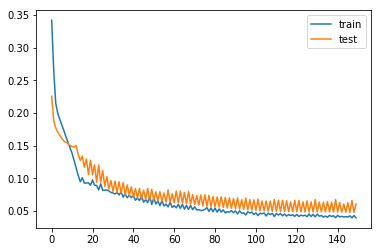

In [668]:
# fit network
history_cnn_lstm = model.fit(train_X_cnn_lstm, train_y, epochs=150, batch_size=72, validation_data=(test_X_cnn_lstm, test_y), verbose=1, shuffle=False)
# plot history
plt.plot(history_cnn_lstm.history['loss'], label='train')
plt.plot(history_cnn_lstm.history['val_loss'], label='test')
plt.legend()
plt.show()

In [669]:
# make a prediction
preds_cnn_lstm = model.predict(test_X_cnn_lstm)

orignal_preds_cnn_lstm = scale_back_labels(test_X, preds_cnn_lstm)
real = scale_back_labels(test_X, test_y)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(real, orignal_preds_cnn_lstm))
print('Test RMSE for CNN-LSTM: ', rmse)
print('Test MAE for CNN-LSTM: ', mean_absolute_error(real, orignal_preds_cnn_lstm))

Test RMSE for CNN-LSTM:  1.6597315266360577
Test MAE for CNN-LSTM:  1.26175425518054


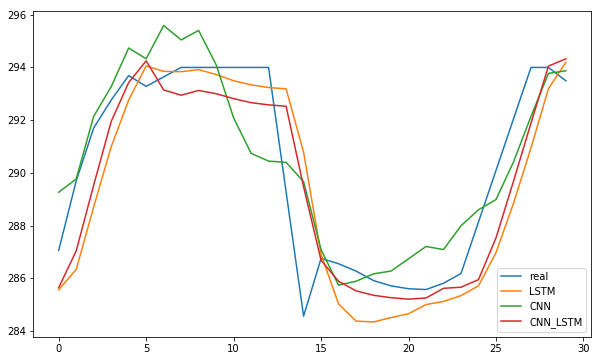

In [686]:
plt.figure(figsize = (10,6))
plt.plot(real, label = "real")
plt.plot(orignal_preds, label = "LSTM")
plt.plot(orignal_preds_cnn, label = "CNN")
plt.plot(orignal_preds_cnn_lstm, label = "CNN_LSTM")
#plt.plot(range(len(preds_varmax.loc["temperature"])),preds_varmax.loc["temperature"], label = "predict varmax")
#plt.plot(range(len(preds_var[2])), preds_var[2], label = "predict var")
plt.legend()